In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
from nltk.stem import WordNetLemmatizer # analyze meaning behind a word
import string # string processing
import pickle # save and load py objects 
import numpy as np # data structures
from nltk.corpus import stopwords # for extracting stop words
from nltk import pos_tag # for POS tagging
from nltk.corpus import wordnet # lexical database
import matplotlib.pyplot as plt # data visualization
import tensorflow as tf #tensorflow 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense
from keras.backend import eval
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D,MaxPooling1D
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hotel-reviews-eu/Hotel_Reviews.csv


In [2]:
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
# Functions
def get_pos(pos_tag):
    """Extract wordnet value corresponding to POS tag
    
    Keyword arguments:
    pos_tag : POS tag
    """
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    else:
        return wordnet.NOUN

def clean_review(review):
    """Data preprocessing
    
    Keyword arguments:
    review : A single product review
    """
    review = str(review)
    # convert to lowercase
    review = review.lower()
    # tokenize and strip punctuations
    review = [word.strip(string.punctuation) for word in review.split(' ')]
    # remove alphanumeric words
    review = [word for word in review if not any(char.isdigit() for char in word)]
    # remove stop words
    stop = stopwords.words('english')
    review = [x for x in review if x not in stop]
    review = [x for x in review if len(x) > 0]
    # POS tagging
    pos_tags = pos_tag(review)
    # lemmatize
    review = [WordNetLemmatizer().lemmatize(x[0], get_pos(x[1])) for x in pos_tags]
    review = [t for t in review if len(t) > 1]
    review = ' '.join(review)
    return review

In [4]:
# Import dataset
hr_raw_df = pd.read_csv('/kaggle/input/hotel-reviews-eu/Hotel_Reviews.csv')
hr_raw_df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


In [5]:
# Concatenate positive and negative reviews
hr_df = hr_raw_df.copy()
hr_df['review'] = hr_raw_df['Negative_Review'] + ' ' + hr_raw_df['Positive_Review']
# Select relevant columns
hr_df['score'] = hr_df['Reviewer_Score']
hr_df = hr_df[['review', 'score']]
hr_df.head(10) # Table 1

,review,score
0,I am so angry that i made this post available...,2.9
1,No Negative No real complaints the hotel was ...,7.5
2,Rooms are nice but for elderly a bit difficul...,7.1
3,My room was dirty and I was afraid to walk ba...,3.8
4,You When I booked with your company on line y...,6.7
5,Backyard of the hotel is total mess shouldn t...,6.7
6,Cleaner did not change our sheet and duvet ev...,4.6
7,Apart from the price for the brekfast Everyth...,10.0
8,Even though the pictures show very clean room...,6.5
9,The aircondition makes so much noise and its ...,7.9


In [6]:
hr_df['review'] = hr_df['review'].apply(lambda x: x.replace('No Negative', '').replace('No Positive', ''))
hr_df.head(10)

,review,score
0,I am so angry that i made this post available...,2.9
1,No real complaints the hotel was great great...,7.5
2,Rooms are nice but for elderly a bit difficul...,7.1
3,My room was dirty and I was afraid to walk ba...,3.8
4,You When I booked with your company on line y...,6.7
5,Backyard of the hotel is total mess shouldn t...,6.7
6,Cleaner did not change our sheet and duvet ev...,4.6
7,Apart from the price for the brekfast Everyth...,10.0
8,Even though the pictures show very clean room...,6.5
9,The aircondition makes so much noise and its ...,7.9


In [7]:
# Apply data preprocessing
hr_df['review'] = hr_df['review'].apply(lambda x: clean_review(x))
hr_df.head(10)

,review,score
0,angry make post available via possible site us...,2.9
1,real complaint hotel great great location surr...,7.5
2,room nice elderly bit difficult room two story...,7.1
3,room dirty afraid walk barefoot floor look cle...,3.8
4,book company line show picture room think get ...,6.7
5,backyard hotel total mess happen hotel star go...,6.7
6,clean change sheet duvet everyday make bed als...,4.6
7,apart price brekfast everything good good loca...,10.0
8,even though picture show clean room actual roo...,6.5
9,aircondition make much noise hard sleep night ...,7.9


In [8]:
# Generate labels
hr_median_score = np.median(np.sort(hr_df['score'].unique()))
hr_df['label'] = hr_df['score'].apply(lambda x: 'negative' if x < hr_median_score 
                                      else('neutral' if x == hr_median_score else 'positive'))
hr_df.head(10)

,review,score,label
0,angry make post available via possible site us...,2.9,negative
1,real complaint hotel great great location surr...,7.5,positive
2,room nice elderly bit difficult room two story...,7.1,positive
3,room dirty afraid walk barefoot floor look cle...,3.8,negative
4,book company line show picture room think get ...,6.7,positive
5,backyard hotel total mess happen hotel star go...,6.7,positive
6,clean change sheet duvet everyday make bed als...,4.6,negative
7,apart price brekfast everything good good loca...,10.0,positive
8,even though picture show clean room actual roo...,6.5,positive
9,aircondition make much noise hard sleep night ...,7.9,positive


In [9]:
sentences = hr_df['review']
labels = hr_df['label']

In [10]:
#Create Tokenizer to tokenize and produce a bag of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

In [11]:
text_sequences = np.array(tokenizer.texts_to_sequences(sentences))
sequence_dict = tokenizer.word_index
word_dict = dict((num, val) for (val, num) in sequence_dict.items())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [12]:
# Map word to numeric code for feeding in training
review_cleans = [doc.split(' ') for doc in sentences]
reviews_encoded = [];
for i,review in enumerate(review_cleans):
    reviews_encoded.append([sequence_dict[x] for x in review if x !=''])

(array([  528.,  6511., 19559., 21009., 26068., 24900., 25915., 24884.,
        24046., 22591., 21300., 19709., 18450., 17228., 16248., 14915.,
        14015., 13008., 12179., 11373., 10416.,  9856.,  8963., 15987.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <BarContainer object of 24 artists>)

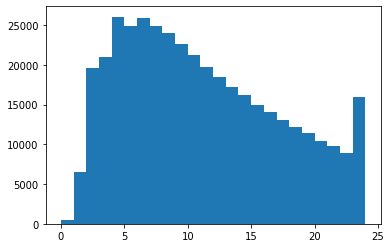

In [13]:
lengths = [len(x) for x in reviews_encoded]
plt.hist(lengths, bins=range(25))

In [14]:
max_cap =8;
X = pad_sequences(reviews_encoded, maxlen=max_cap, truncating='post')
Y = np.array([[0,1] if 'negative' in label else [1,0] for label in labels])

In [15]:
# Adding code to reproduce the training
np.random.seed(1024);
random_posits = np.arange(len(X))
np.random.shuffle(random_posits);

In [16]:
# Spritting data into train, test, eval
X = X[random_posits]
Y = Y[random_posits]
train_perc = int(0.85 * len(X))
val_perc = int(0.93 * len(X))
X_train, Y_train = X[:train_perc], Y[:train_perc]
X_val, Y_val = X[train_perc:val_perc], Y[train_perc:val_perc]
X_test, Y_test = X[val_perc:], Y[val_perc:]

In [17]:
# Create Model
model = Sequential();
model.add(Embedding(len(word_dict)+1, max_cap, input_length=max_cap));
#adding a LSTM layer of dim 1--
model.add(LSTM(200, return_sequences=True));
model.add(LSTM(200, return_sequences=False));
#adding a dense layer with activation function of relu
model.add(Dense(100, activation='relu',kernel_initializer='uniform'));#best 50,relu
#adding the final output activation with activation function of softmax
model.add(Dense(2, activation='sigmoid', kernel_initializer='uniform'));
print(model.summary());

2022-01-21 22:28:57.042171: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-21 22:28:57.204019: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-21 22:28:57.204782: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-21 22:28:57.206000: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8, 8)              564568    
_________________________________________________________________
lstm (LSTM)                  (None, 8, 200)            167200    
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense (Dense)                (None, 100)               20100     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 1,072,870
Trainable params: 1,072,870
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
#Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
# Fit the model and train for 5 epochs, save this history for plot
history = model.fit(X_train, Y_train, batch_size=16, epochs=5, validation_data=(X_val, Y_val))

2022-01-21 22:29:00.044184: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-01-21 22:29:03.869943: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


27399/27399 [==============================] - 179s 6ms/step - loss: 0.2448 - accuracy: 0.9049 - val_loss: 0.2364 - val_accuracy: 0.9072
Epoch 2/5
27399/27399 [==============================] - 176s 6ms/step - loss: 0.2276 - accuracy: 0.9095 - val_loss: 0.2347 - val_accuracy: 0.9079
Epoch 3/5
20680/27399 [=====================>........] - ETA: 41s - loss: 0.2197 - accuracy: 0.9125

In [ ]:
score = model.evaluate(X_test, Y_test)
print("Test accuracy: %0.4f%%" % (score[1]*100))

In [ ]:
# Save the model
model.save('./my_model')

In [ ]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss [Binary Crossentropy]')
plt.title('Keras training progress');